# Medical Insurance Cost Prediction #

## Prepare Tools ##

In [21]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot

# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import backend

from numpy.random import seed
seed(0)

## Load and Inspect Data ##

In [2]:
working_dir = "/home/lee/Documents/Datasets for GitHub/kaggle_individual_medical_cost/"
df = pd.read_csv(working_dir+'insurance.csv', index_col=False)

In [3]:
print("dataframe shape: {}".format(df.shape))
print("\n")
print("preview:\n{}".format(df.head()))
print("\n")
print("summary:\n{}".format(df.describe()))
print("\n")
print("categorical variable counts:")
print(df[['sex', 'smoker', 'region']].nunique())
print("\n")
print("columns with at least 1 NaN value: \n{}".format(df.columns[df.isna().any()].tolist()))

dataframe shape: (1338, 7)


preview:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


summary:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


categorical variable counts:
sex  

Observations:
* The dataset has no missing values at all. 
* All feature values seem to be within reasonable ranges, respectively. Usually a dataset used in a challenge will have some imperfections and data cleaning is part of the solution. 
* The dataset has only 1338 rows, making it very small by machine learning standards. Insufficient training data sometimes leads to overfitting and we need to control the number of features. 
* "Charges" appears right-skewed. Use visualization to decide whether we need to transform it. 

## EDA ##

We first create pairwise scatterplots of all continuous variables.

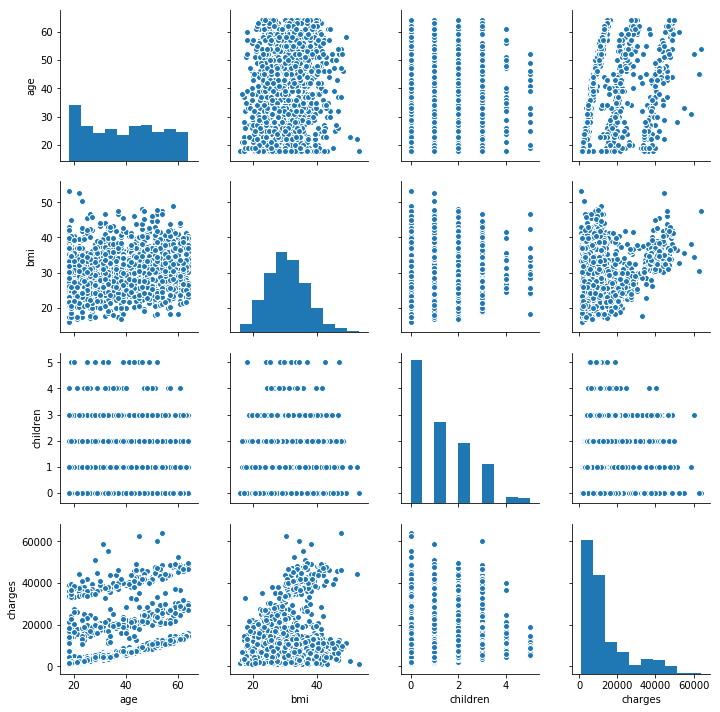

In [4]:
sns.pairplot(df)

Now boxplots for categorical variables:

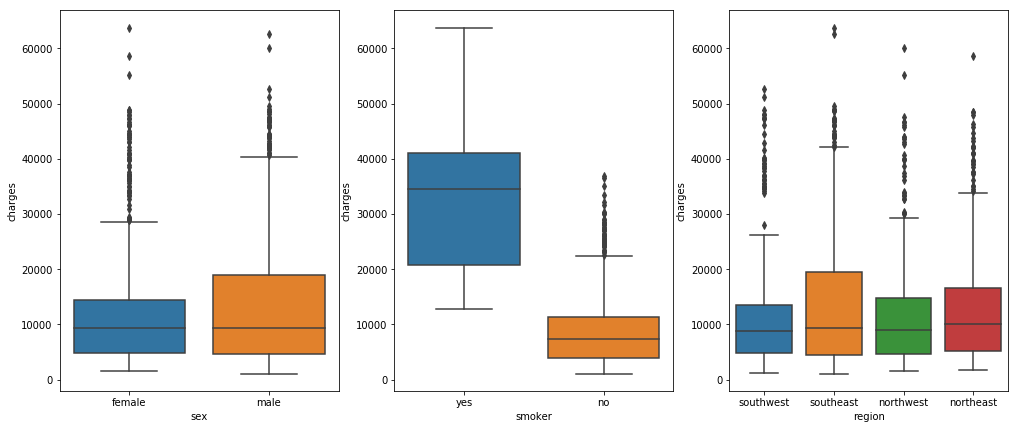

In [5]:
f, axes = plt.subplots(1, 3, figsize=(17, 7))
sns.boxplot(x=df["sex"], y=df["charges"], ax=axes[0])
sns.boxplot(x="smoker", y="charges", data=df, ax=axes[1])    
sns.boxplot(x="region", y="charges", data=df, ax=axes[2]) 
plt.show()

Observations:
* Charges increase with age.
* It seems charges has three distinctive buckets. 
* Definitely need to transform charges. 
* BMI is a big blob - I don't see a visible trend between it and the target or any other predictor variables. It also has a nice bell-shaped distribution. I will not normalize or standardize this variable. It probably is not a strong predictor. 
* Smoking status will likely be a strong predictor. 

## Process Data ##

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("charges", axis=1), df["charges"], test_size = 0.33,\
                                                    random_state=0)

All charges values are positive, meaning that we can use box-cox transformation on it. 
Don't forget to save the lambda value. 

In [8]:
y_train_t, lmbda_train = boxcox(y_train)

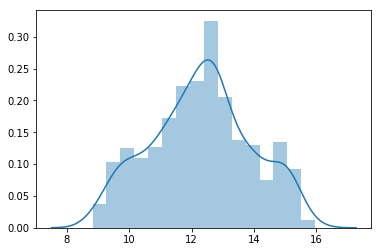

In [9]:
sns.distplot(y_train_t)

The distribution looks much better now. 

Encode the categorical variables:

In [10]:
X_train_onehot_encoded = pd.concat([X_train[['age', 'bmi', 'children']],\
                                    pd.get_dummies(X_train[['sex', 'smoker', 'region']])], axis=1)

X_test_onehot_encoded = pd.concat([X_test[['age', 'bmi', 'children']],\
                                    pd.get_dummies(X_test[['sex', 'smoker', 'region']])], axis=1)

y_test_t = boxcox(y_test, lmbda=lmbda_train)

## Model the Data ##

### Train Random Forest Model ###

In [11]:
rf = RandomForestRegressor(oob_score=True, random_state=0)
rf.fit(X_train_onehot_encoded, y_train_t)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

### Plot the Predictions ###

In [12]:
predicted_rf = inv_boxcox(rf.predict(X_test_onehot_encoded), lmbda_train)

actual costs vs. predicted costs, random forest:


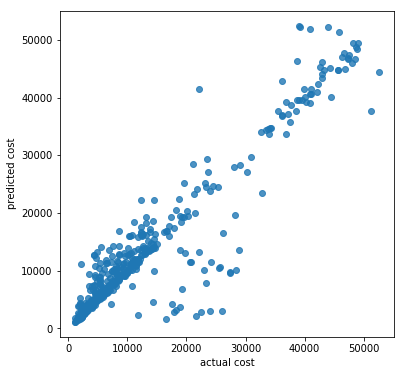

In [13]:
print("actual costs vs. predicted costs, random forest:")
fig, _ = plt.subplots()
fig.set_size_inches(6, 6)
ax = sns.regplot(y_test, predicted_rf, fit_reg=False)
ax.set(xlabel='actual cost', ylabel='predicted cost')
plt.show()

The actual and predicted costs more or less form a straight $y=x$ line. But it is concerning that a number of predictions are lower than the actual costs. Business-wise this is a worse problem than the other way around - an insurance company that underestimates patients' health risk will likely suffer unexpected financial loss while providing patients less preventive care than they should have received. Lose-lose situation. We want to err on the side of overestimating. 

For the following discussion on feature importance I will continue using the random forest model, which I trained using its default "symmetric" cost function. After that I will build a shallow neural network with a custom cost function using `Keras`. 

### Feature Importance ###

In [14]:
print('Training OOB error rate: {0:0.4f}'.format(1 - rf.oob_score_))

Training OOB error rate: 1.1361


Feature importance:
age = 0.3739
bmi = 0.1050
children = 0.0317
sex_female = 0.0058
sex_male = 0.0061
smoker_no = 0.3128
smoker_yes = 0.1375
region_northeast = 0.0118
region_northwest = 0.0060
region_southeast = 0.0033
region_southwest = 0.0060


Plotting feature importance:


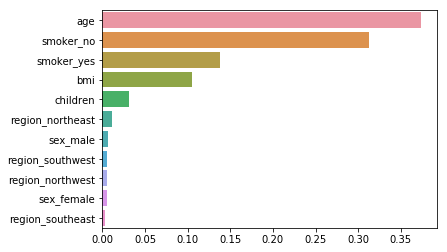

In [15]:
print("Feature importance:")
for name, importance in zip(X_train_onehot_encoded.columns, rf.feature_importances_):
    print(name, "=", "{0:0.4f}".format(importance));
print("\n")

print("Plotting feature importance:")
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
ax = sns.barplot(x=importances[indices], y=np.array(X_train_onehot_encoded.columns)[indices])

### Partial Dependence Plot ###

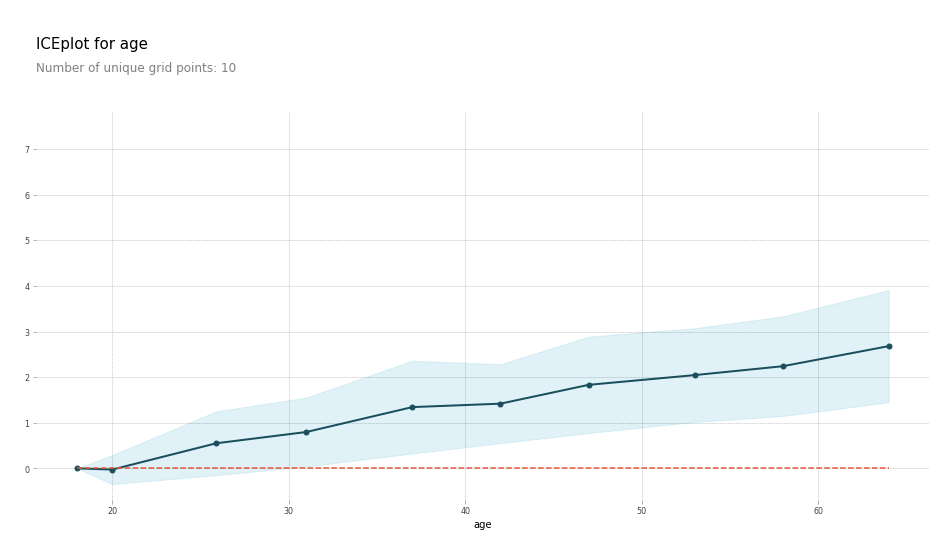

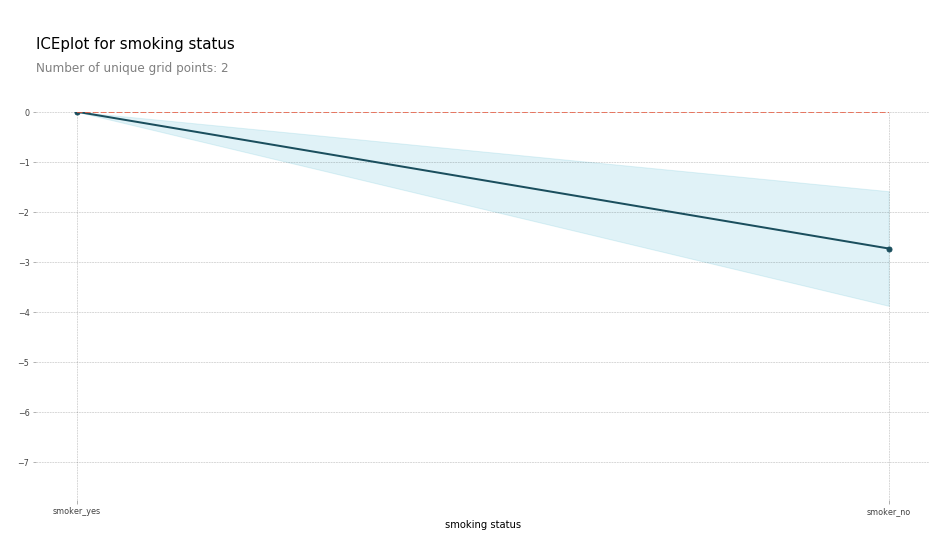

In [16]:
pdp_plot(pdp_isolate(rf, X_train_onehot_encoded, 'age'), 'age')
plt.show()

pdp_plot(pdp_isolate(rf, X_train_onehot_encoded, feature=['smoker_yes', 'smoker_no']), 'smoking status')
plt.show()

Age and smoking are the strongest predictors. These results agree with what we saw earlier in the EDA. Age is not directly actionable but we have the option to reach out to older patients and take preventive measures, e.g., reminding them to schedule office visits with their primary care physicians. Smoking on the other hand is actionable; one approach is to establish and promote smoking cessation programs. 

We also find that region is a weak predictor of cost. This implies that all our regions have similar performances, which is desirable. 

### Train Neural Network ###

Earlier we discussed the business benefit of erring on the side of overestimating. We can define a simple "asymmetric" cost function by modifying the squared loss:
$\mathcal L: (x,\alpha) \to x^2 \left( \mathrm{sign} (x) + \alpha \right)^2$

where $−1<\alpha<1$ is a parameter we can use to trade off the penalty of underestimation against overestimation. To penalize underestimation, we want to set $\alpha$ negative. 

Define custom cost function:

In [17]:
def custom_cost(y_true, y_pred):
    return backend.pow(y_pred-y_true, 2) * backend.pow(backend.sign(y_pred-y_true) + a, 2)

Build model:

In [22]:
model = Sequential()
model.add(Dense(len(X_train_onehot_encoded.columns), input_dim=len(X_train_onehot_encoded.columns), kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

a = -0.5
model.compile(loss=custom_cost, optimizer='adam')

model.fit(X_train_onehot_encoded, y_train_t, epochs=64, batch_size=1, verbose=0)

Make predictions:

In [23]:
predicted_nn = inv_boxcox(model.predict(X_test_onehot_encoded), lmbda_train)

actual costs vs. predicted costs:


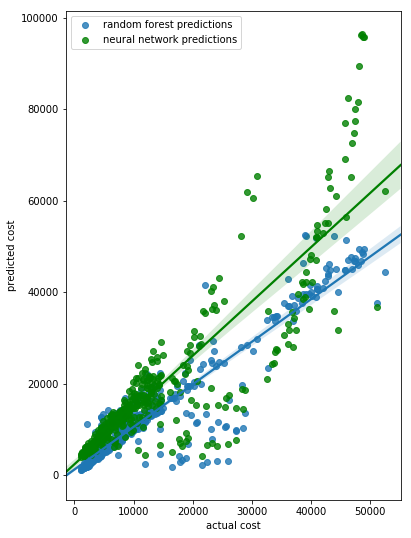

In [25]:
print("actual costs vs. predicted costs:")
fig, ax = plt.subplots()
fig.set_size_inches(6, 9)
sns.regplot(x=y_test, y=predicted_rf, ax=ax, label="random forest predictions")
sns.regplot(x=y_test, y=predicted_nn.flatten(), ax=ax, color='green', label='neural network predictions')
ax.legend()
ax.set(xlabel='actual cost', ylabel='predicted cost')
plt.show()

Our neural network model gives higher predicted costs than the random forest model. In business practice I need to consult with the finance/risk departments to see whether this strategy strikes the trade-off we desire. 